# Exploring the Capabilities of the STMicroelectonics Sensor Tile

<div style="text-align: center; ">
<figure>
  <img src="img/sensor_tile.png" alt="STEVAL-STWINKT1" style="background:none; border:none; box-shadow:none; text-align:center" width="400px"/>
</figure>
</div>

## Sensing Elements
The STEVAL-STWINKT1 sensor tile contains nine sensing elements (as shown in the figure below):

* **Vibrometer (IIS3DWB)**: Max Sampling Freq = 26.667 kHz
* **3D Accelerometer (IIS2DH)**: Max Sampling Freq = 1344 Hz
* **6-Axis Inertial-Measurement-Unit (ISM330DHCX)**: Max Sampling Freq = 6667 Hz
* **Humidity and Temperature (HTS221)**: Max Sampling Freq = 12.5 Hz
* **Temperature (STTS751)**: Max Sampling Freq = 4 Hz
* **Pressure (LPS22HH)**: Max Sampling Freq = 200 Hz, sensor contains both pressure and temperature
* **3D Magnetometer (IIS2MDC)**: Max Sampling Freq = 100 Hz
* **Analog Microphone (MP23ABS1)**: Max Sampling Freq = 192 kHz
* **Digital Microphone (IMP34DT05)**: Max Sampling Freq = 48 kHz, Suitable for vibration monitoring



![sensing elements](img/sensing_elements.png)

## Collecting and Analyzing Data

STMicroelectronics provides [high-speed data-logging firmware](https://www.st.com/en/embedded-software/fp-sns-datalog1.html?ecmp=tt9470_gl_link_feb2019&rt=um&id=UM2621) and an associated Python package for analyzing the data.

I collected data from the fan, as shown in the picture below.

<div style="text-align: center; ">
<figure>
  <img src="img/fan.jpg" alt="fan and sensor tile" style="background:none; border:none; box-shadow:none; text-align:center" width="500px"/>
  <div style="text-align: center; ">
  <figcaption style="color:grey; font-size:smaller"> The fan configuration for collecting data.</figcaption>
  </div>
</figure>
</div>


Import the high-speed data-logger package.

In [1]:
from HSD import HSDatalog as HSD
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal, fftpack

Set the location of the collected data and initialize the HSDatalog class.

In [56]:
acq_folder = "/home/tim/Documents/High-Speed-Datalog/data/STWIN_00006" # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

HSDatalog allows you to obtain all the information regarding the acquisition and the board that generated it.

In [57]:
active_sensor_list = hsd.getSensorList(only_active=True)

# print information on each sensor
for sens in active_sensor_list:
    sensor_name = sens.name
    sensor = hsd.getSensor(sensor_name)
    print ("Sensor: {}".format(sensor.name))
    
    # can get the capabilities (descriptor) for each sensor
    s_descriptor_list = sensor.sensor_descriptor.sub_sensor_descriptor
    
    # can get configuration of sensor
    s_status_list = sensor.sensor_status.sub_sensor_status
    
    for i, s in enumerate(s_descriptor_list):
        print(f" --> {s.sensor_type} - ODR: {s_status_list[i].odr} , FS: {s_status_list[i].fs} , SamplesPerTs {s_status_list[i].samples_per_ts} , Unit: {s.unit}")

Sensor: IIS3DWB
 --> ACC - ODR: 26667.0 , FS: 16.0 , SamplesPerTs 1000 , Unit: g
Sensor: HTS221
 --> TEMP - ODR: 12.5 , FS: 120.0 , SamplesPerTs 50 , Unit: Celsius
 --> HUM - ODR: 12.5 , FS: 100.0 , SamplesPerTs 50 , Unit: %
Sensor: IIS2DH
 --> ACC - ODR: 1344.0 , FS: 16.0 , SamplesPerTs 1000 , Unit: g
Sensor: IIS2MDC
 --> MAG - ODR: 100.0 , FS: 50.0 , SamplesPerTs 100 , Unit: gauss
Sensor: IMP34DT05
 --> MIC - ODR: 48000.0 , FS: 122.5 , SamplesPerTs 1000 , Unit: Waveform
Sensor: ISM330DHCX
 --> ACC - ODR: 6667.0 , FS: 16.0 , SamplesPerTs 1000 , Unit: g
 --> GYRO - ODR: 6667.0 , FS: 4000.0 , SamplesPerTs 1000 , Unit: mdps
Sensor: LPS22HH
 --> PRESS - ODR: 200.0 , FS: 1260.0 , SamplesPerTs 200 , Unit: hPa
 --> TEMP - ODR: 200.0 , FS: 85.0 , SamplesPerTs 200 , Unit: Celsius
Sensor: MP23ABS1
 --> MIC - ODR: 192000.0 , FS: 130.0 , SamplesPerTs 1000 , Unit: Waveform
Sensor: STTS751
 --> TEMP - ODR: 4.0 , FS: 100.0 , SamplesPerTs 20 , Unit: Celsius


We can also get the list of sensor data files in your selected acquisition folder:

In [58]:
file_names = hsd.getDataFileList()
print(file_names)

['HTS221_TEMP.dat', 'LPS22HH_PRESS.dat', 'IIS2DH_ACC.dat', 'ISM330DHCX_GYRO.dat', 'IIS3DWB_ACC.dat', 'LPS22HH_TEMP.dat', 'IMP34DT05_MIC.dat', 'STTS751_TEMP.dat', 'ISM330DHCX_ACC.dat', 'MP23ABS1_MIC.dat', 'HTS221_HUM.dat', 'IIS2MDC_MAG.dat']


### Visualize Data
Let's look at the vibrometer, IIS3DWB. First, we will put it into a Pandas dataframe.

In [93]:
acq_folder = "/home/tim/Documents/High-Speed-Datalog/data/STWIN_00006" # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

sensor_name = "IIS3DWB"
sensor_type = "ACC"

# HSD method for extracting info into pandas dataframe
df = hsd.get_dataFrame(sensor_name, sensor_type)
df.head()

,Time,A_x [g],A_y [g],A_z [g]
0,0.129849,0.031232,-0.090280,1.104832
1,0.129886,0.025376,-0.118096,1.107760
2,0.129924,0.027328,-0.096624,1.107272
3,0.129961,0.045384,-0.110288,1.084824
4,0.129998,0.011224,-0.112240,1.096536


The HSDatalog also has some built in methods for quickly visualizing the data (but we will build our own too).

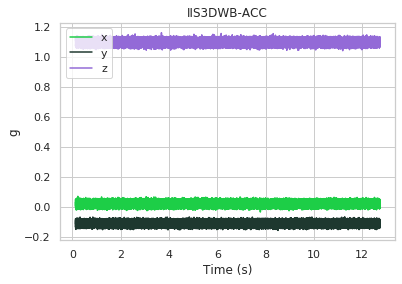

In [84]:
hsd.get_sensorPlot(sensor_name, sensor_type)

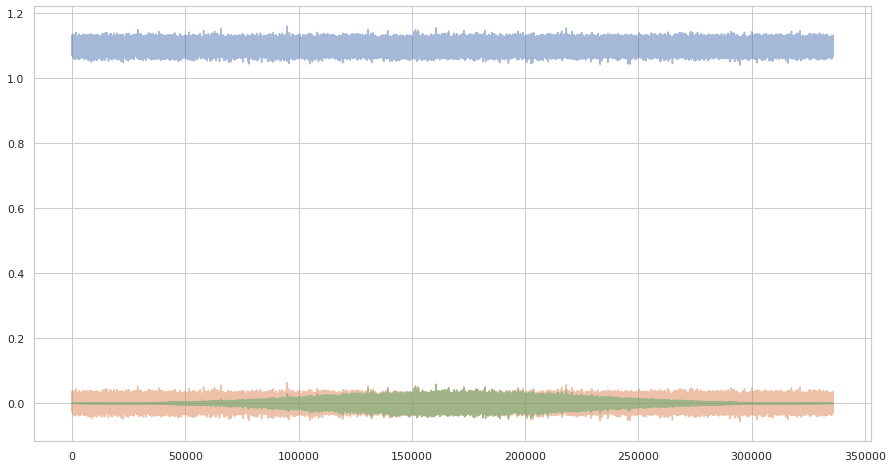

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['A_z [g]'], alpha=0.5)
y_detrend = signal.detrend(df['A_z [g]'], type="linear")
plt.plot(y_detrend, alpha=0.5)
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 8)
plt.plot(y_detrend, alpha=0.5)

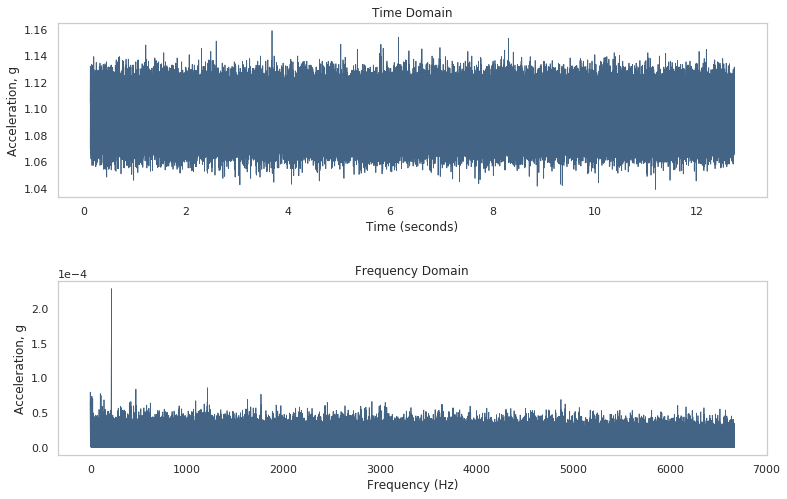

In [94]:
def create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True):

    y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    x = df[x_name].to_numpy(dtype="float64")

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points
    
    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal
#     y_detrend *= np.hamming(N)  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    y_detrend *= np.kaiser(len(y_detrend), 8)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)/2

    if show_plot:
        # setup the seaborn plot
        sns.set(font_scale=1.0, style="whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
        fig.tight_layout(pad=5.0)

        pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

        # plot time domain signal
        axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
        axes[0].set_xlabel("Time (seconds)")
        axes[0].set_ylabel("Acceleration, g")
        # axes[0].set_yticklabels([])

        # plot the frequency domain signal
        axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Acceleration, g")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        

        # clean up the sub-plots to make everything pretty
        for ax in axes.flatten():
            ax.yaxis.set_tick_params(labelleft=True, which="major")
            ax.grid(False)
            
        # in case you want to save the figure (just uncomment)
        # plt.savefig('time_freq_domains.svg',dpi=600,bbox_inches = "tight")
        plt.show()
    
    return xf, yf

t_start = df['Time'].iloc[0]
t_end = df['Time'].iloc[-1]



xf, yf = create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True)

It looks like, from the above frequency domain plot, that we have a frequency peak at approximately 500 Hz. I would guess that this is the rotational speed of the fan. Let's zoom in to get a better look.

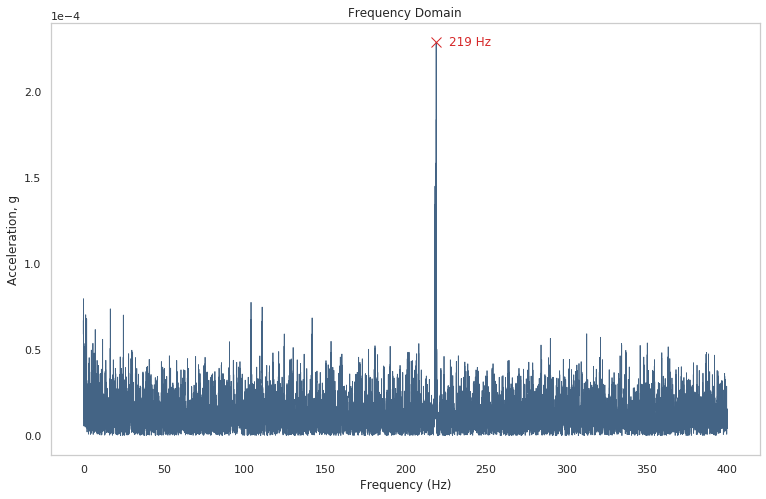

In [95]:
def plot_freq(xf, yf, max_freq_to_plot=1000, peak_height=0.0001, peak_distance=100):

    # select the index number where xf is less than a certain freq
    i = np.where(xf<max_freq_to_plot)[0][-1]

    # setup the seaborn plot
    sns.set(font_scale=1.0, style="whitegrid")
    fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=False, sharey=False)
    fig.tight_layout(pad=5.0)
    
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

    # plot the frequency domain signal
    axes.plot(xf[:i], yf[:i], marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes.set_title("Frequency Domain", fontdict={"fontweight": "normal"})
    axes.set_xlabel("Frequency (Hz)")
    axes.set_ylabel("Acceleration, g")
    axes.yaxis.set_tick_params(labelleft=True, which="major")
    axes.grid(False)

    peaks, _ = signal.find_peaks(yf[:i], height=peak_height, distance=peak_distance)
    plt.plot(xf[peaks], yf[peaks], "x", color='#d62728', markersize=10)

    for p in peaks:
        axes.text(
            x=xf[p]+max_freq_to_plot/50.0,
            y=yf[p],
            s=f"{xf[p]:.0f} Hz",
            horizontalalignment="left",
            verticalalignment="center",
            size=12,
            color="#d62728",
            rotation="horizontal",
            weight="normal",
        )

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show()
    

plot_freq(xf, yf, max_freq_to_plot=400)

Now let's see how that changes when the fan is running at a "high" speed.

In [96]:
acq_folder = "/home/tim/Documents/High-Speed-Datalog/data/STWIN_00008" # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

sensor_name = "IIS3DWB"
sensor_type = "ACC"

# HSD method for extracting info into pandas dataframe
df = hsd.get_dataFrame(sensor_name, sensor_type)
df.head()

,Time,A_x [g],A_y [g],A_z [g]
0,0.129849,0.045384,-0.098576,1.089216
1,0.129893,0.020496,-0.126392,1.099464
2,0.129937,0.020984,-0.107848,1.100440
3,0.129981,0.020496,-0.114192,1.084824
4,0.130025,0.022936,-0.111264,1.104832


Plot the time and frequency domain.

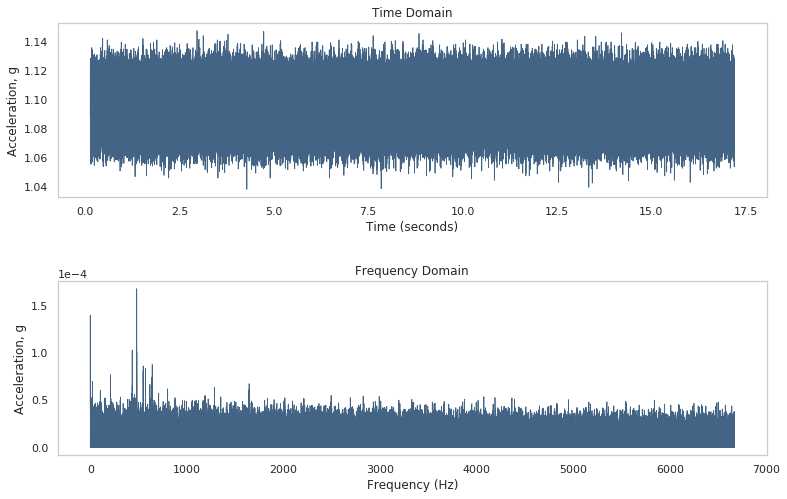

In [97]:
xf, yf = create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True)

Plot only the frquency domain, but zoomed in.

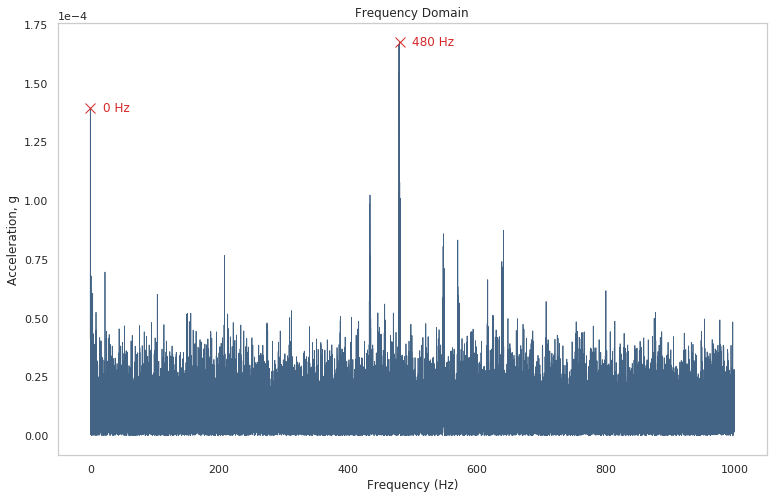

In [100]:
plot_freq(xf, yf, max_freq_to_plot=1000, peak_height=0.000125,peak_distance=100)

Now lets look at the data from when we were shaking the senor tile up and down (at approximately 1 Hz)

In [101]:
acq_folder = "/home/tim/Documents/High-Speed-Datalog/data/STWIN_00010_shaking" # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

sensor_name = "IIS3DWB"
sensor_type = "ACC"

# HSD method for extracting info into pandas dataframe
df = hsd.get_dataFrame(sensor_name, sensor_type)
df.head()

,Time,A_x [g],A_y [g],A_z [g]
0,0.129849,0.124440,-0.318176,0.179584
1,0.130073,0.107848,-0.366976,0.167872
2,0.130298,0.122976,-0.343552,0.161040
3,0.130522,0.104920,-0.356240,0.152256
4,0.130746,0.110776,-0.369416,0.178120


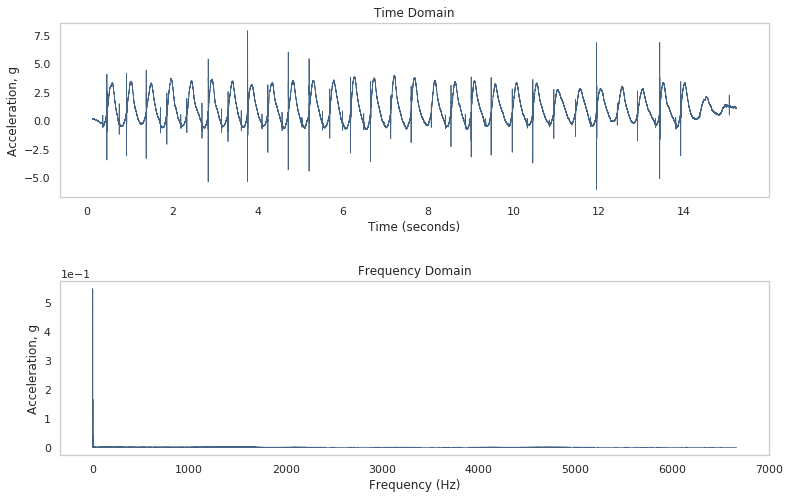

In [102]:
xf, yf = create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True)

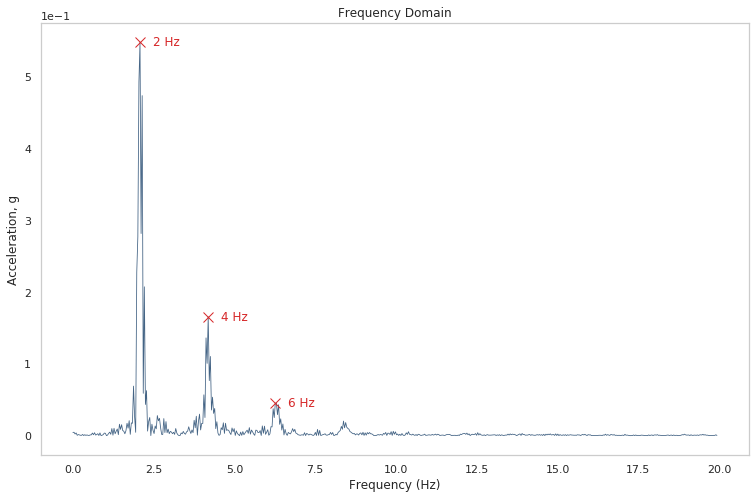

In [108]:
plot_freq(xf, yf, max_freq_to_plot=20, peak_height=0.04,peak_distance=10)

We can plot all the sensors the same way.

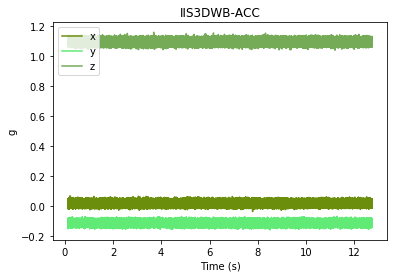

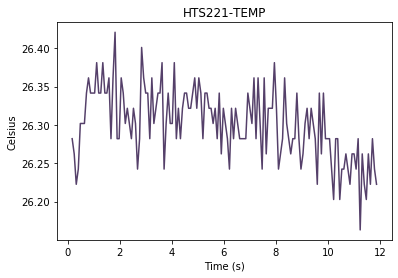

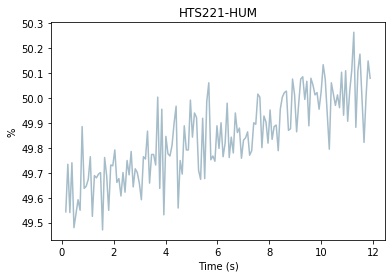

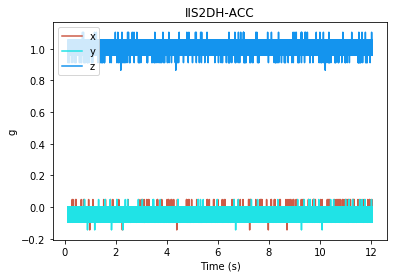

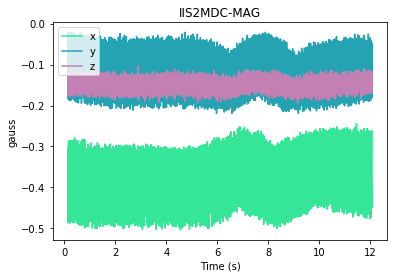

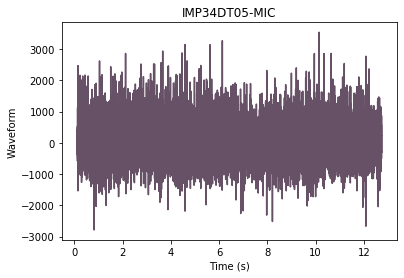

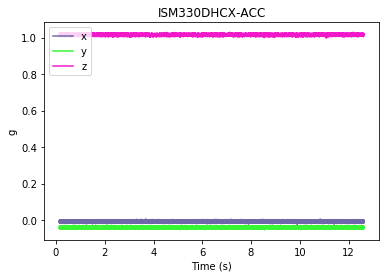

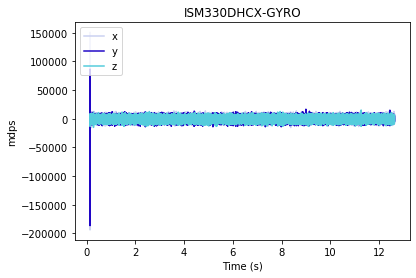

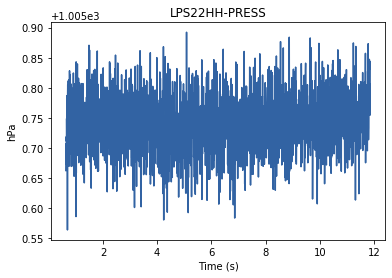

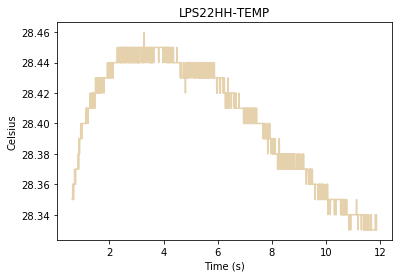

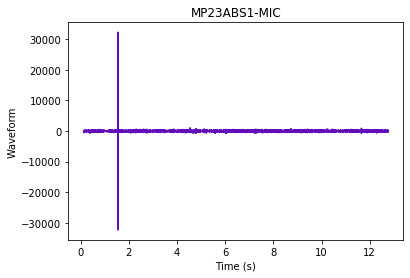

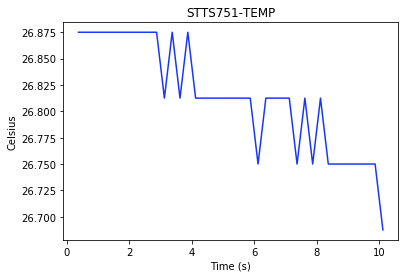

In [51]:
active_sensor_list = hsd.getSensorList(only_active=True)

plots = []
for s in active_sensor_list:
    for ssd in s.sensor_descriptor.sub_sensor_descriptor:
        hsd.get_sensorPlot(s.name, ssd.sensor_type)

In [29]:
df = hsd.get_dataFrame(sensor_name,sensor_type, sample_start = 10, sample_end = 20)
df.describe()

,Time,MIC
count,10.000000,10.00000
mean,0.128668,-62.30000
std,0.001158,163.39118
min,0.126946,-224.00000
25%,0.127807,-208.50000
50%,0.128668,-111.50000
75%,0.129528,83.00000
max,0.130389,172.00000


Add labels to the exported DataFrame (if they are present in the acquisition)

In [30]:
df = hsd.get_dataFrame(sensor_name, sensor_type, labeled = True)
print(df)

            Time    MIC
0       0.123121  -25.0
1       0.123504   33.0
2       0.123886  123.0
3       0.124269  189.0
4       0.124651  192.0
...          ...    ...
644995  3.859779    3.0
644996  3.859784    2.0
644997  3.859789    3.0
644998  3.859795    0.0
644999  3.859800    0.0

[645000 rows x 2 columns]


Raw data selection. Data will not be multiplied by the sensor sensitivity value

In [25]:
df = hsd.get_dataFrame(sensor_name, sensor_type, raw_flag = True)
df.describe()

,Time,MIC
count,161000.000000,161000.000000
mean,2.169709,-1.800528
std,0.970438,232.312919
min,0.116802,-3613.000000
25%,1.332345,-2.000000
50%,2.170881,0.000000
75%,3.009417,5.000000
max,3.847954,4220.000000


# Data Conversion
---
Starting from a DataFrame it is possible to convert the data of an acquisition in the following formats:
<ul>
<li> CSV, TSV
<li> Cartesiam format
<li> ST UNICO format (Work in progress)
</ul>
To access the conversion features, we have to:
<ul>
<li> Import the HSD_utils.converters module.
<li> choose a folder to save the conversion output files
</ul>


In [11]:
from HSD_utils.converters import HSDatalogConverter
import os

output_folder = "saved_data"
# output_folder = "..\\STWIN_acquisition_examples\\20201110_16_22_19\\exported_data_folder"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Select a sensor and obtain a DataFrame from the corresponding acquisition file

In [12]:
# sensor_name = "IIS3DWB"
# sensor_type = "ACC"
df = hsd.get_dataFrame(sensor_name, sensor_type)

## CSV, TSV Conversion

In [13]:
exported_sensor_path = os.path.join(output_folder,sensor_name)

HSDatalogConverter.to_csv(df, exported_sensor_path)
# HSDatalogConverter.to_tsv(df, exported_sensor_path)

--> File: "saved_data/IMP34DT05.csv" correctly exported


## Cartesiam format Conversion

In [ ]:
# HSDatalogConverter.to_cartesiam_format(output_folder, sensor_name, df, 150)

## ST UNICO format Conversion (Work in progress)

In [ ]:
# hsd.to_unico(output_folder,sensor_name='ISM330DHCX')

# Plot
---
Using the HSDatalog module it is possible to visualize the data of an acquisition as follows
- You can plot one sensor:

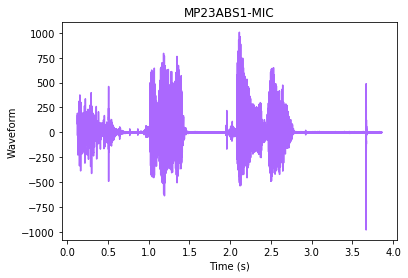

In [27]:
import matplotlib.pyplot as plt
sensor_name = "MP23ABS1"
sensor_type = "MIC"

hsd.get_sensorPlot(sensor_name, sensor_type)

Or all of them:

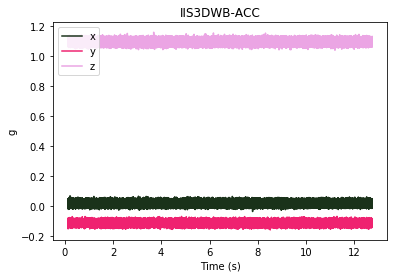

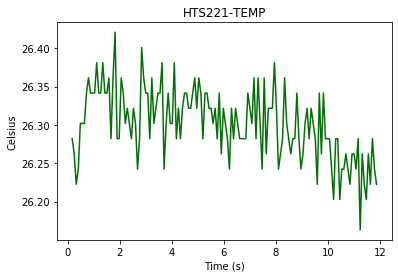

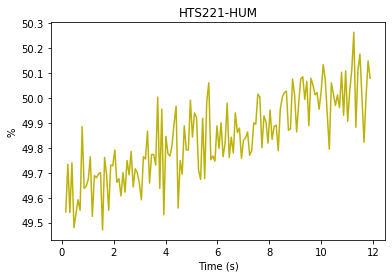

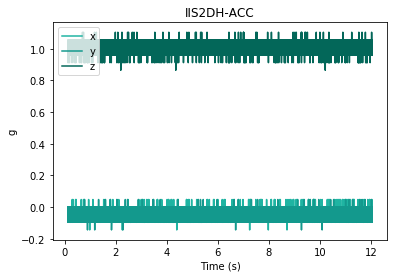

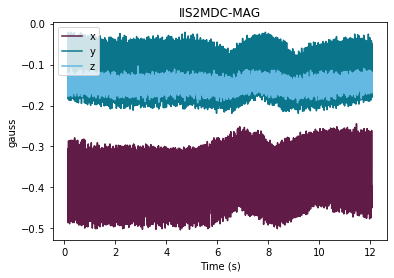

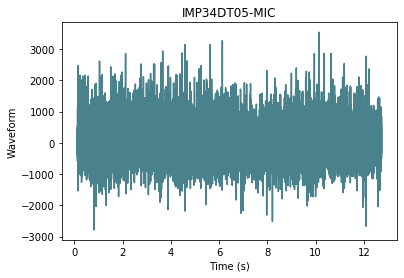

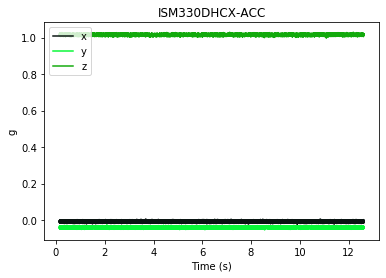

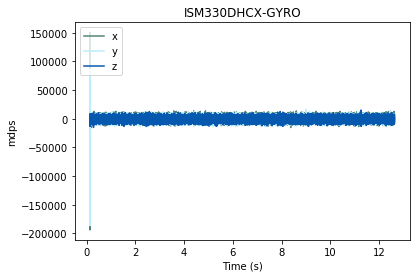

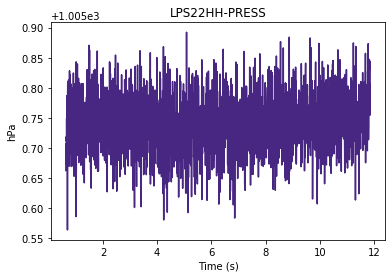

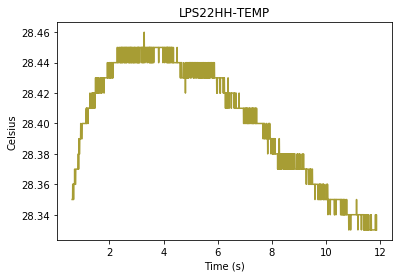

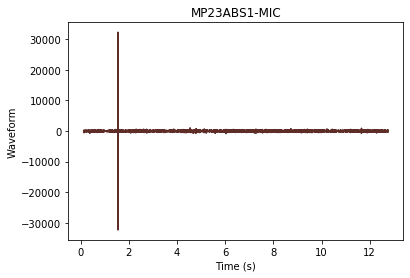

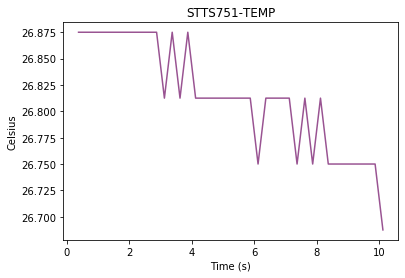

In [19]:
active_sensor_list = hsd.getSensorList(only_active=True)

plots = []
for s in active_sensor_list:
    for ssd in s.sensor_descriptor.sub_sensor_descriptor:
        hsd.get_sensorPlot(s.name, ssd.sensor_type)

The module provides a set of options to personalize the plots
- It is possible to limit the plot to a specific samples interval

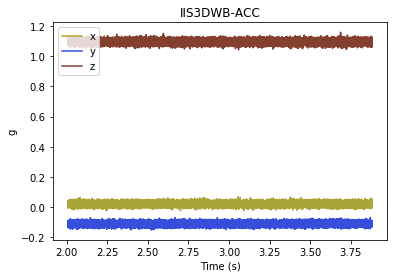

In [20]:
sensor_name = "IIS3DWB"
sensor_type = "ACC"

hsd.get_sensorPlot(sensor_name, sensor_type, sample_start=50000, sample_end=100000)

- To display data annotations (acquisition must be annotated)

[]
No HW_TAG_0 label found in selected acquisition


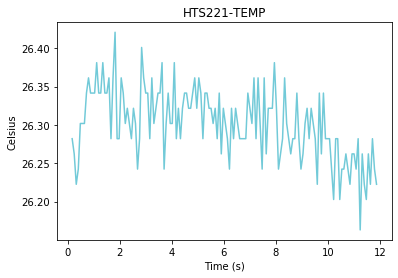

In [21]:
label_list = hsd.getAcquisitionLabelClasses()
print(label_list)

sensor_name = "HTS221"
sensor_type = "TEMP"
hsd.get_sensorPlot(sensor_name, sensor_type, label='HW_TAG_0')

- To display a sub-plot for each dimension, in case of multidimensional sensors

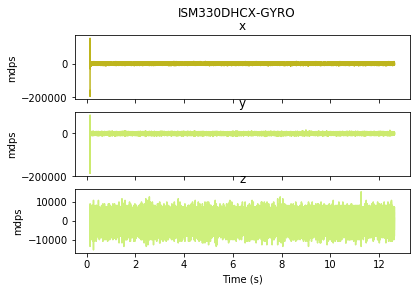

In [22]:
sensor_name = "ISM330DHCX"
sensor_type = "GYRO"
hsd.get_sensorPlot(sensor_name, sensor_type, subplots=True)

- To show raw data (not multiplied by sensitivity)

sensitivity: 0.000488


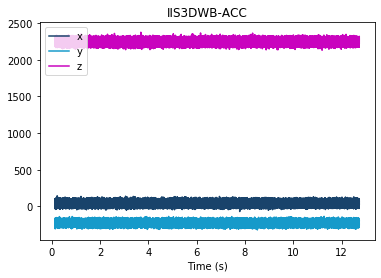

In [59]:
sensor_name = "IIS3DWB"
sensor_type = "ACC"

sensor = hsd.getSensor(sensor_name)
sensor_sensitivity = sensor.sensor_status.sub_sensor_status[0].sensitivity
print("sensitivity: {}".format(sensor_sensitivity))

hsd.get_sensorPlot(sensor.name, sensor_type, raw_flag=True)